In [1]:
import os 
import numpy as np
import pandas as pd 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize, word_tokenize


/usr/local/anaconda/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
dictionary_path = os.path.join('../../data/raw/pos_neg_list.csv')
print(os.getcwd())
print(dictionary_path)

/mnt/notebook/poc
../../data/raw/pos_neg_list.csv


In [46]:
new_text ='''  4. The economic recovery is not beneficial pace (Figure 1) . In 2017Q1, GDP expanded by 0.5 percent y-o-y (0.3 percent y-o-y in 2016Q4), supported by an acceleration in consumption and investment. An improvement in credit demand from households, particularly for mortgage loans— benefitting from a combination of a government subsidy program and easing inflation—is supporting credit growth, which reached 2.5 percent y-o-y in March 2017. A negative output gap, ruble appreciation and declining food prices from a strong harvest, have contributed to decreasing inflation, which reached 4.1 percent in April, down from 7.2 percent a year before.  '''

sent_text = sent_tokenize(new_text)
new_tokens = word_tokenize(new_text)
new_tokens =[x.lower() for x in new_tokens]

### BoW approach

[Reference: Correa, Ricardo, Keshav Garud, Juan M. Londono, and Nathan Mislang (2017). Sentiment in Central Banks’ Financial Stability Reports. International Finance Discussion Papers 1203.](https://www.federalreserve.gov/econres/notes/ifdp-notes/constructing-a-dictionary-for-financial-stability-20170623.htm)

In [14]:
## Load neg and pos dictionary and create pos and neg list
word_dict = pd.read_csv(dictionary_path)
pos_list = word_dict[word_dict['Positive']==1]['Word'].to_list()
neg_list = word_dict[word_dict['Negative']==1]['Word'].to_list()

# define negation word list
negation_list = ['not','no','nobody','none','never','neither','cannot']

In [52]:
def count_words_in_paragraph(paragraph, pos_list, neg_list, negation_list):
    
    '''return sentiment score ss, 
       only negate positive words'''
    
    window = 3
    
    n_pos = sum([paragraph.count(x) for x in pos_list])
    n_neg = sum([paragraph.count(x) for x in neg_list])
    n_total = len(paragraph)
    
    ## calculate number of negation words in the window of +/-3 next to n_pos 
    
    pos_index = [i for i, val in enumerate(paragraph) if val in pos_list]
    pos_range_lower = np.array(pos_index) - window
    pos_range_upper = np.array(pos_index) + window
    
    negation_index = [i for i, val in enumerate(paragraph) if val in negation_list]
    
    
    pos_range_lower = np.repeat(pos_range_lower, len(negation_index))    
    pos_range_upper = np.repeat(pos_range_upper, len(negation_index))
    
    negation_index = np.repeat(negation_index, n_pos)
    
    n_negation = np.sum( (pos_range_lower < negation_index) & (pos_range_upper > negation_index) )
    
    sentiment_score = (n_pos-n_negation - n_neg) / n_total
    
    return sentiment_score

X = count_words_in_paragraph(paragraph=new_tokens, pos_list=pos_list, neg_list=neg_list, negation_list = negation_list)
X

0.0

### 2. Vader (trained on twitter)

In [5]:
sid = SentimentIntensityAnalyzer()
for sentence in sent_text:
    print(sentence)
    ss = sid.polarity_scores(sentence)
    for k in sorted(ss):
        print('{0}:{1}'.format(k, ss[k]), end ='\n')

  High NPLs and large volatility of deposits affected lending, and in 2017, private sector credit was flat.
compound:0.25
neg:0.083
neu:0.781
pos:0.135
After the Halyk-KKB merger and NBK actions on smaller banks, there are signs that lending is picking up.
compound:0.0
neg:0.0
neu:1.0
pos:0.0
While the May
2018 stock of private sector credit was only slightly higher than a year ago, this reflected write-offs, loan portfolio restructuring, and banks whose licenses were revoked.
compound:0.3818
neg:0.0
neu:0.912
pos:0.088
Taking these developments
into account, credit growth stood at 11.5 percent, with the main driver being consumer loans to households.
compound:0.6369
neg:0.0
neu:0.776
pos:0.224
Insufficient demand by creditworthy borrowers, along with limited availability of longterm funding, are key constraints to a faster corporate credit growth.
compound:0.7351
neg:0.126
neu:0.556
pos:0.319


In [6]:
sentences = ["VADER is smart, handsome, and funny.", # positive sentence example
...    "VADER is smart, handsome, and funny!", # punctuation emphasis handled correctly (sentiment intensity adjusted)
...    "VADER is very smart, handsome, and funny.",  # booster words handled correctly (sentiment intensity adjusted)
...    "VADER is VERY SMART, handsome, and FUNNY.",  # emphasis for ALLCAPS handled
...    "VADER is VERY SMART, handsome, and FUNNY!!!",# combination of signals - VADER appropriately adjusts intensity
...    "VADER is VERY SMART, really handsome, and INCREDIBLY FUNNY!!!",# booster words & punctuation make this close to ceiling for score
...    "The book was good.",         # positive sentence
...    "The book was kind of good.", # qualified positive sentence is handled correctly (intensity adjusted)
...    "The plot was good, but the characters are uncompelling and the dialog is not great.", # mixed negation sentence
...    "A really bad, horrible book.",       # negative sentence with booster words
...    "At least it isn't a horrible book.", # negated negative sentence with contraction
...    ":) and :D",     # emoticons handled
...    "",              # an empty string is correctly handled
...    "Today sux",     #  negative slang handled
...    "Today sux!",    #  negative slang with punctuation emphasis handled
...    "Today SUX!",    #  negative slang with capitalization emphasis
...    "Today kinda sux! But I'll get by, lol" # mixed sentiment example with slang and constrastive conjunction "but"
... ]

In [7]:
for sentence in sentences:
    print(sentence)
    ss = sid.polarity_scores(sentence)
    print('{0}:{1}'.format('compound', ss['compound']), end ='\n')

VADER is smart, handsome, and funny.
compound:0.8316
VADER is smart, handsome, and funny!
compound:0.8439
VADER is very smart, handsome, and funny.
compound:0.8545
VADER is VERY SMART, handsome, and FUNNY.
compound:0.9227
VADER is VERY SMART, handsome, and FUNNY!!!
compound:0.9342
VADER is VERY SMART, really handsome, and INCREDIBLY FUNNY!!!
compound:0.9469
The book was good.
compound:0.4404
The book was kind of good.
compound:0.3832
The plot was good, but the characters are uncompelling and the dialog is not great.
compound:-0.7042
A really bad, horrible book.
compound:-0.8211
At least it isn't a horrible book.
compound:0.431
:) and :D
compound:0.7925

compound:0.0
Today sux
compound:-0.3612
Today sux!
compound:-0.4199
Today SUX!
compound:-0.5461
Today kinda sux! But I'll get by, lol
compound:0.2228


### 3. Liu Hu- simple word count without dealing with negation

In [9]:
from nltk.sentiment.util import demo_liu_hu_lexicon

  High NPLs and large volatility of deposits affected lending, and in 2017, private sector credit was flat.
Negative


/usr/local/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


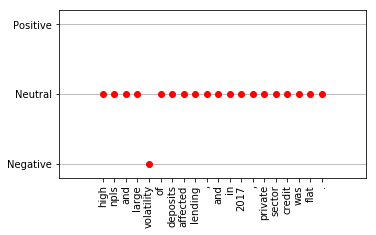

None
After the Halyk-KKB merger and NBK actions on smaller banks, there are signs that lending is picking up.
Neutral


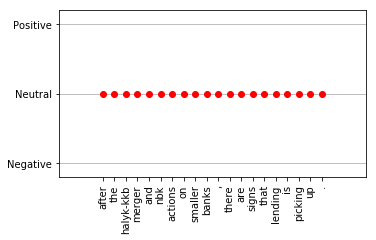

None
While the May
2018 stock of private sector credit was only slightly higher than a year ago, this reflected write-offs, loan portfolio restructuring, and banks whose licenses were revoked.
Positive


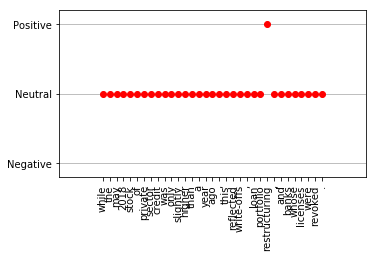

None
Taking these developments
into account, credit growth stood at 11.5 percent, with the main driver being consumer loans to households.
Neutral


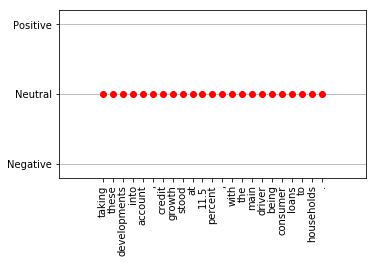

None
Insufficient demand by creditworthy borrowers, along with limited availability of longterm funding, are key constraints to a faster corporate credit growth.
Negative


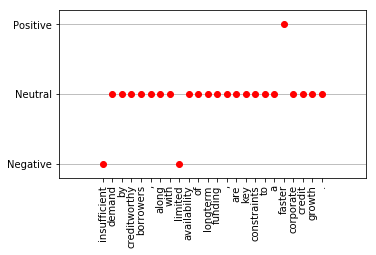

None


In [13]:
for sentence in sent_text:
    print(sentence)
    ss = demo_liu_hu_lexicon(sentence, plot = True)
    print(ss)

In [16]:
demo_liu_hu_lexicon('not good at all')

Positive
